# DEPT Response Factor Analysis

This notebook calculates the optimal coherence transfer delay and tip angle for DEPT experiments.  Below, you can input the 1-bond coupling constants and multiplicities (CH, CH<sub>2</sub>, CH<sub>3</sub>) of the peaks of interest.  This program will then return the response factors and optimal parameters for DEPT.

Note that this program requires the `lmfit` [package](https://lmfit.github.io/lmfit-py/).

In [1]:
# load libraries
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
from IPython.display import display, HTML
from math import sin, cos, radians
from itertools import product
from lmfit import minimize, Parameter, Parameters, report_fit
import random
import sys

## User Data

Enter your 1-bond coupling constants and multiplicities below.  Only enter in values for the peaks of interest.

In [2]:
couplings = [ 119, 127, 125, 140, 150]  # one-bond carbon-proton coupling constants in Hz
multiplicities = [ 1,3, 3, 2, 1]        # n in CHn, where n is the number of protons
peaks = zip(couplings,multiplicities)

In [3]:
# define polynomial powers of trigonometric functions
def sin2(x):
    return pow(sin(x),2.0)
def sin4(x):
    return pow(sin(x),4.0)
def sin6(x):
    return pow(sin(x),6.0)
def cos2(x):
    return pow(cos(x),2.0)
def cos4(x):
    return pow(cos(x),4.0)
def cos6(x):
    return pow(cos(x),2.0)
pi = np.pi

In [4]:
# product operator functions
# delta = magnetization transfer delay (seconds)
# J = coupling constant (Hz)
# theta = tip angle (radians)
# returns the DEPT response factor

# product operators for a methine
def CH(delta,J,theta):
    return 4.0*sin2(pi*delta*J)*sin(theta)

# product operators for a methylene
def CH2(delta,J,theta):
    arg = pi*delta*J
    term1 = sin4(arg)*cos(theta)
    term2 = sin2(arg)*cos2(arg)
    return 8.0*sin(theta)*(term1+term2)

# product operators for a methyl
def CH3(delta,J,theta):
    arg = pi*delta*J
    term1 = sin6(arg)*sin(theta)*cos2(theta)
    term2 = sin4(arg)*cos2(arg) *sin(2.0*theta)
    term3 = sin2(arg)*cos4(arg) *sin(theta)
    return 12.0*(term1+term2+term3)

# returns the correction product operator function for
# a given multiplicity
def compute(mult):
    if mult == 1:
        return CH
    elif mult == 2:
        return CH2
    elif mult == 3:
        return CH3

# Optimization Function

You can either maximize the mean response factor or minimize the overall variation in response factors here.

You may wish to input a subset of your peaks of interest in the "User Data" cell to optimize the experiment for certain peaks.

In [5]:
# optimize delta and theta across all peaks
#
# defines the objective function
# x is a vector [delta, theta] that corresponds to the
# delay and angle for a candidate solution
def trial(x):
    x = x.valuesdict().values()
    delta = x[0] / 1000.0            # convert from ms to seconds
    theta = np.radians(x[1])         # convert from degrees to radians
    
    all_peaks = []                   # store the response factors here
    for J,mult in peaks:
        f = compute(mult)            # compute response factors
        this_peak = f(delta,J,theta)
        all_peaks.append(this_peak)
    all_peaks = np.array(all_peaks)
    mean = -np.mean(all_peaks)       # will maximize mean response factor
    stdev = np.std(all_peaks)        # will minimize variation in response factors
    return stdev                      # !!! set to mean or stdev !!!

In [6]:
# function for printing status reports
def iter_cb(params, iteration, residual):
    print "iteration %5d   residual = %18.14f    \r" % (iteration, residual),
    sys.stdout.flush()

# Optimization

This cell performs the optimization.  Please use the optimized parameters in your DEPT experiment.

In [7]:
# perform constrained optimization
delta_min = 2.0
delta_max = 5.0
theta_min = 30.0
theta_max = 90.0

# input a random starting point within the constraints
parameters = Parameters()
parameters.add("delta", value = random.uniform(delta_min, delta_max), min=delta_min, max=delta_max)
parameters.add("theta", value = random.uniform(theta_min, theta_max), min=theta_min, max=theta_max)
#print parameters.valuesdict().values()

# run the optimization
output = minimize(trial, parameters, method="differential_evolution", tol=1e-3)
# use this line instead if you want a status update (slows it down)
#output = minimize(trial, parameters, method="differential_evolution", iter_cb=iter_cb, tol=1e-4)

# report the result
#report_fit(output)
optimal_delta = output.params.valuesdict()["delta"]
optimal_theta = output.params.valuesdict()["theta"]
optimal_delta_s = optimal_delta / 1000.0
optimal_theta_rad = np.radians(optimal_theta)
print "=== Optimized Parameters ==="
print "delta: %6.3f ms      (set j1xh=%.2f)" % (optimal_delta, 1000.0/(2.0*optimal_delta))
print "theta: %6.3f degrees (set mult=%.4f)" % (optimal_theta, optimal_theta/90.0) 
print

=== Optimized Parameters ===
delta:  3.668 ms      (set j1xh=136.31)
theta: 55.691 degrees (set mult=0.6188)



In [8]:
# print a table of the response factors for the optimal values
# a response factor of 3 means the S/N is predicted to be enhanced
# by a factor of 3 over direct carbon detection
peak_labels = ["peak %d" % i for i in range(1,len(peaks)+1)]
types = ["CH%d" % i if i > 1 else "CH" for i in multiplicities]
response_factors = []
for peak in peaks:
    J,mult = peak[0],peak[1]
    f = compute(mult)
    response = f(optimal_delta_s, J, optimal_theta_rad)
    response_factors.append(response)
df = DataFrame({"label":peak_labels,
                "J":couplings,
                "type":types,
                "response":response_factors},
                columns = ["label","type","J","response"])
df.set_index("label",inplace=True)
display(df)

,type,J,response
label,,,
peak 1,CH,119,3.174298
peak 2,CH3,127,3.168610
peak 3,CH3,125,3.177509
peak 4,CH2,140,3.723174
peak 5,CH,150,3.222460


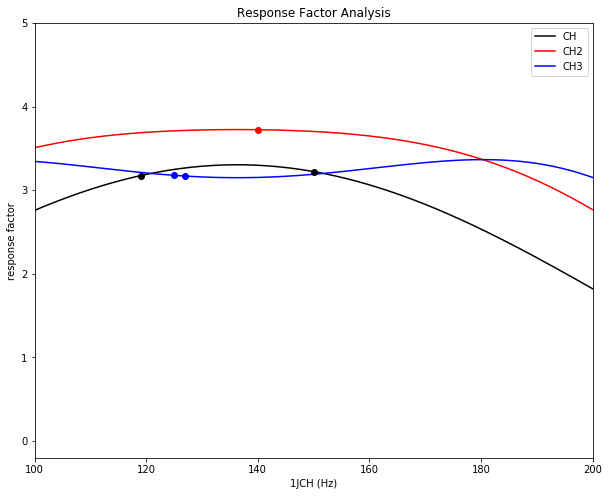

In [9]:
# plot a graph of the variation in response factors vs. coupling constant
# for this customized DEPT experiment
x = np.linspace(100.0, 200.0, 200)   # in Hz
line1 = np.vectorize(CH)(optimal_delta_s,x,optimal_theta_rad)
line2 = np.vectorize(CH2)(optimal_delta_s,x,optimal_theta_rad)
line3 = np.vectorize(CH3)(optimal_delta_s,x,optimal_theta_rad)

plt.figure(figsize=(10,8))
plt.title("Response Factor Analysis")
plt.plot(x,line1,"k", label="CH")
plt.plot(x,line2,"r",label="CH2")
plt.plot(x,line3,"b",label="CH3")
plt.legend(loc="best")
df2=df.query("type == 'CH'")
plt.plot(df2.J, df2.response, "ko")
df2=df.query("type == 'CH2'")
plt.plot(df2.J, df2.response, "ro")
df2=df.query("type == 'CH3'")
plt.plot(df2.J, df2.response, "bo")
plt.xlim(100,200)
plt.ylim(-0.2,5.0)
plt.xlabel("1JCH (Hz)")
plt.ylabel("response factor")
plt.show()